In [1]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython cooler cooltools
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import Phylo
import os
from matplotlib import gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf
import cooler
import cooltools

sns.set_theme(context="paper")

  Using cached cooler-0.10.0-py3-none-any.whl.metadata (9.7 kB)
  Using cached cooltools-0.7.0.tar.gz (8.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [37 lines of output]
      Compiling cooltools/lib/_numutils.pyx because it depends on /private/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/pip-build-env-vefekdi0/overlay/lib/python3.10/site-packages/Cython/Includes/libc/string.pxd.
      [1/1] Cythonizing cooltools/lib/_numutils.pyx
      /private/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/pip-build-env-vefekdi0/overlay/lib/python3.10/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /private/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/pip-install-zwrmeoye/cooltools_32ff25df9

ModuleNotFoundError: No module named 'cooler'

Summarise gene statistics

In [2]:
gff = (
    pl.read_csv(
        "../results/final_annotation/final_annotation.gff",
        separator="\t",
        has_header=False,
        comment_prefix="#",
    )
    .rename(
        {
            "column_1": "seqid",
            "column_2": "source",
            "column_3": "type",
            "column_4": "start",
            "column_5": "end",
            "column_6": "score",
            "column_7": "strand",
            "column_8": "phase",
            "column_9": "attributes",
        }
    )
    .with_columns(
        pl.col("attributes").str.extract(r"ID=(.*?)(?:;|$)").alias("ID"),
        pl.col("attributes").str.extract(r"Parent=(.*?)(?:;|$)").str.split(by=".").alias("Parent"),
    )
    .with_columns(
        (
            pl
            .when(pl.col("Parent").is_null())
            .then(pl.col("ID"))
            .otherwise(pl.col("Parent").list.get(0))
            .alias("gene")
        ),
        (
            pl
            .when(pl.col("Parent").list.len() == 1)
            .then(pl.col("ID").str.split(by=".").list.get(1).str.extract(r"(\d+)"))
            .otherwise(pl.col("Parent").list.get(1).str.extract(r"(\d+)"))
            .cast(pl.Int32)
            .alias("transcript")
        )
    )
    .select([
        "seqid",
        "start",
        "end",
        "strand",
        "gene",
        "transcript",
        "type",
        "attributes",
    ])
)

(
    gff
    .group_by("gene")
    .agg(pl.col("transcript").max().alias("transcript"))
)

gene,transcript
str,i32
"""g6129""",1
"""g17687""",1
"""g24571""",1
"""g29056""",1
"""g8501""",1
…,…
"""g36132""",1
"""g21995""",1
"""g36700""",1


In [4]:
gc = (
    pl.read_csv(
        "../results/windows/gc.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("gc").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_5").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

genes = (
    pl.read_csv(
        "../results/windows/genes.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("genes").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

ty1 = (
    pl.read_csv(
        "../results/windows/Ty1.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("ty1").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

ty3 = (
    pl.read_csv(
        "../results/windows/Ty3.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("ty3").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

methylation = (
    pl.read_csv(
        "../results/windows/methylation.tab",
        has_header=False,
        separator="\t",
        comment_prefix="#",
    )
    .rename(
        {
            "column_1": "chrom",
            "column_2": "start",
            "column_3": "end",
            "column_4": "CG",
            "column_5": "CHG",
            "column_6": "CHH",
        }
    )
    .melt(id_vars=["chrom", "start", "end"], variable_name="feature", value_name="proportion")
)

features_df = pl.concat([gc, genes, ty1, ty3, methylation], how = "align")


/Users/moraysmith/miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/moraysmith/miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/moraysmith/miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/moraysmith/miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/moraysmith/minifo

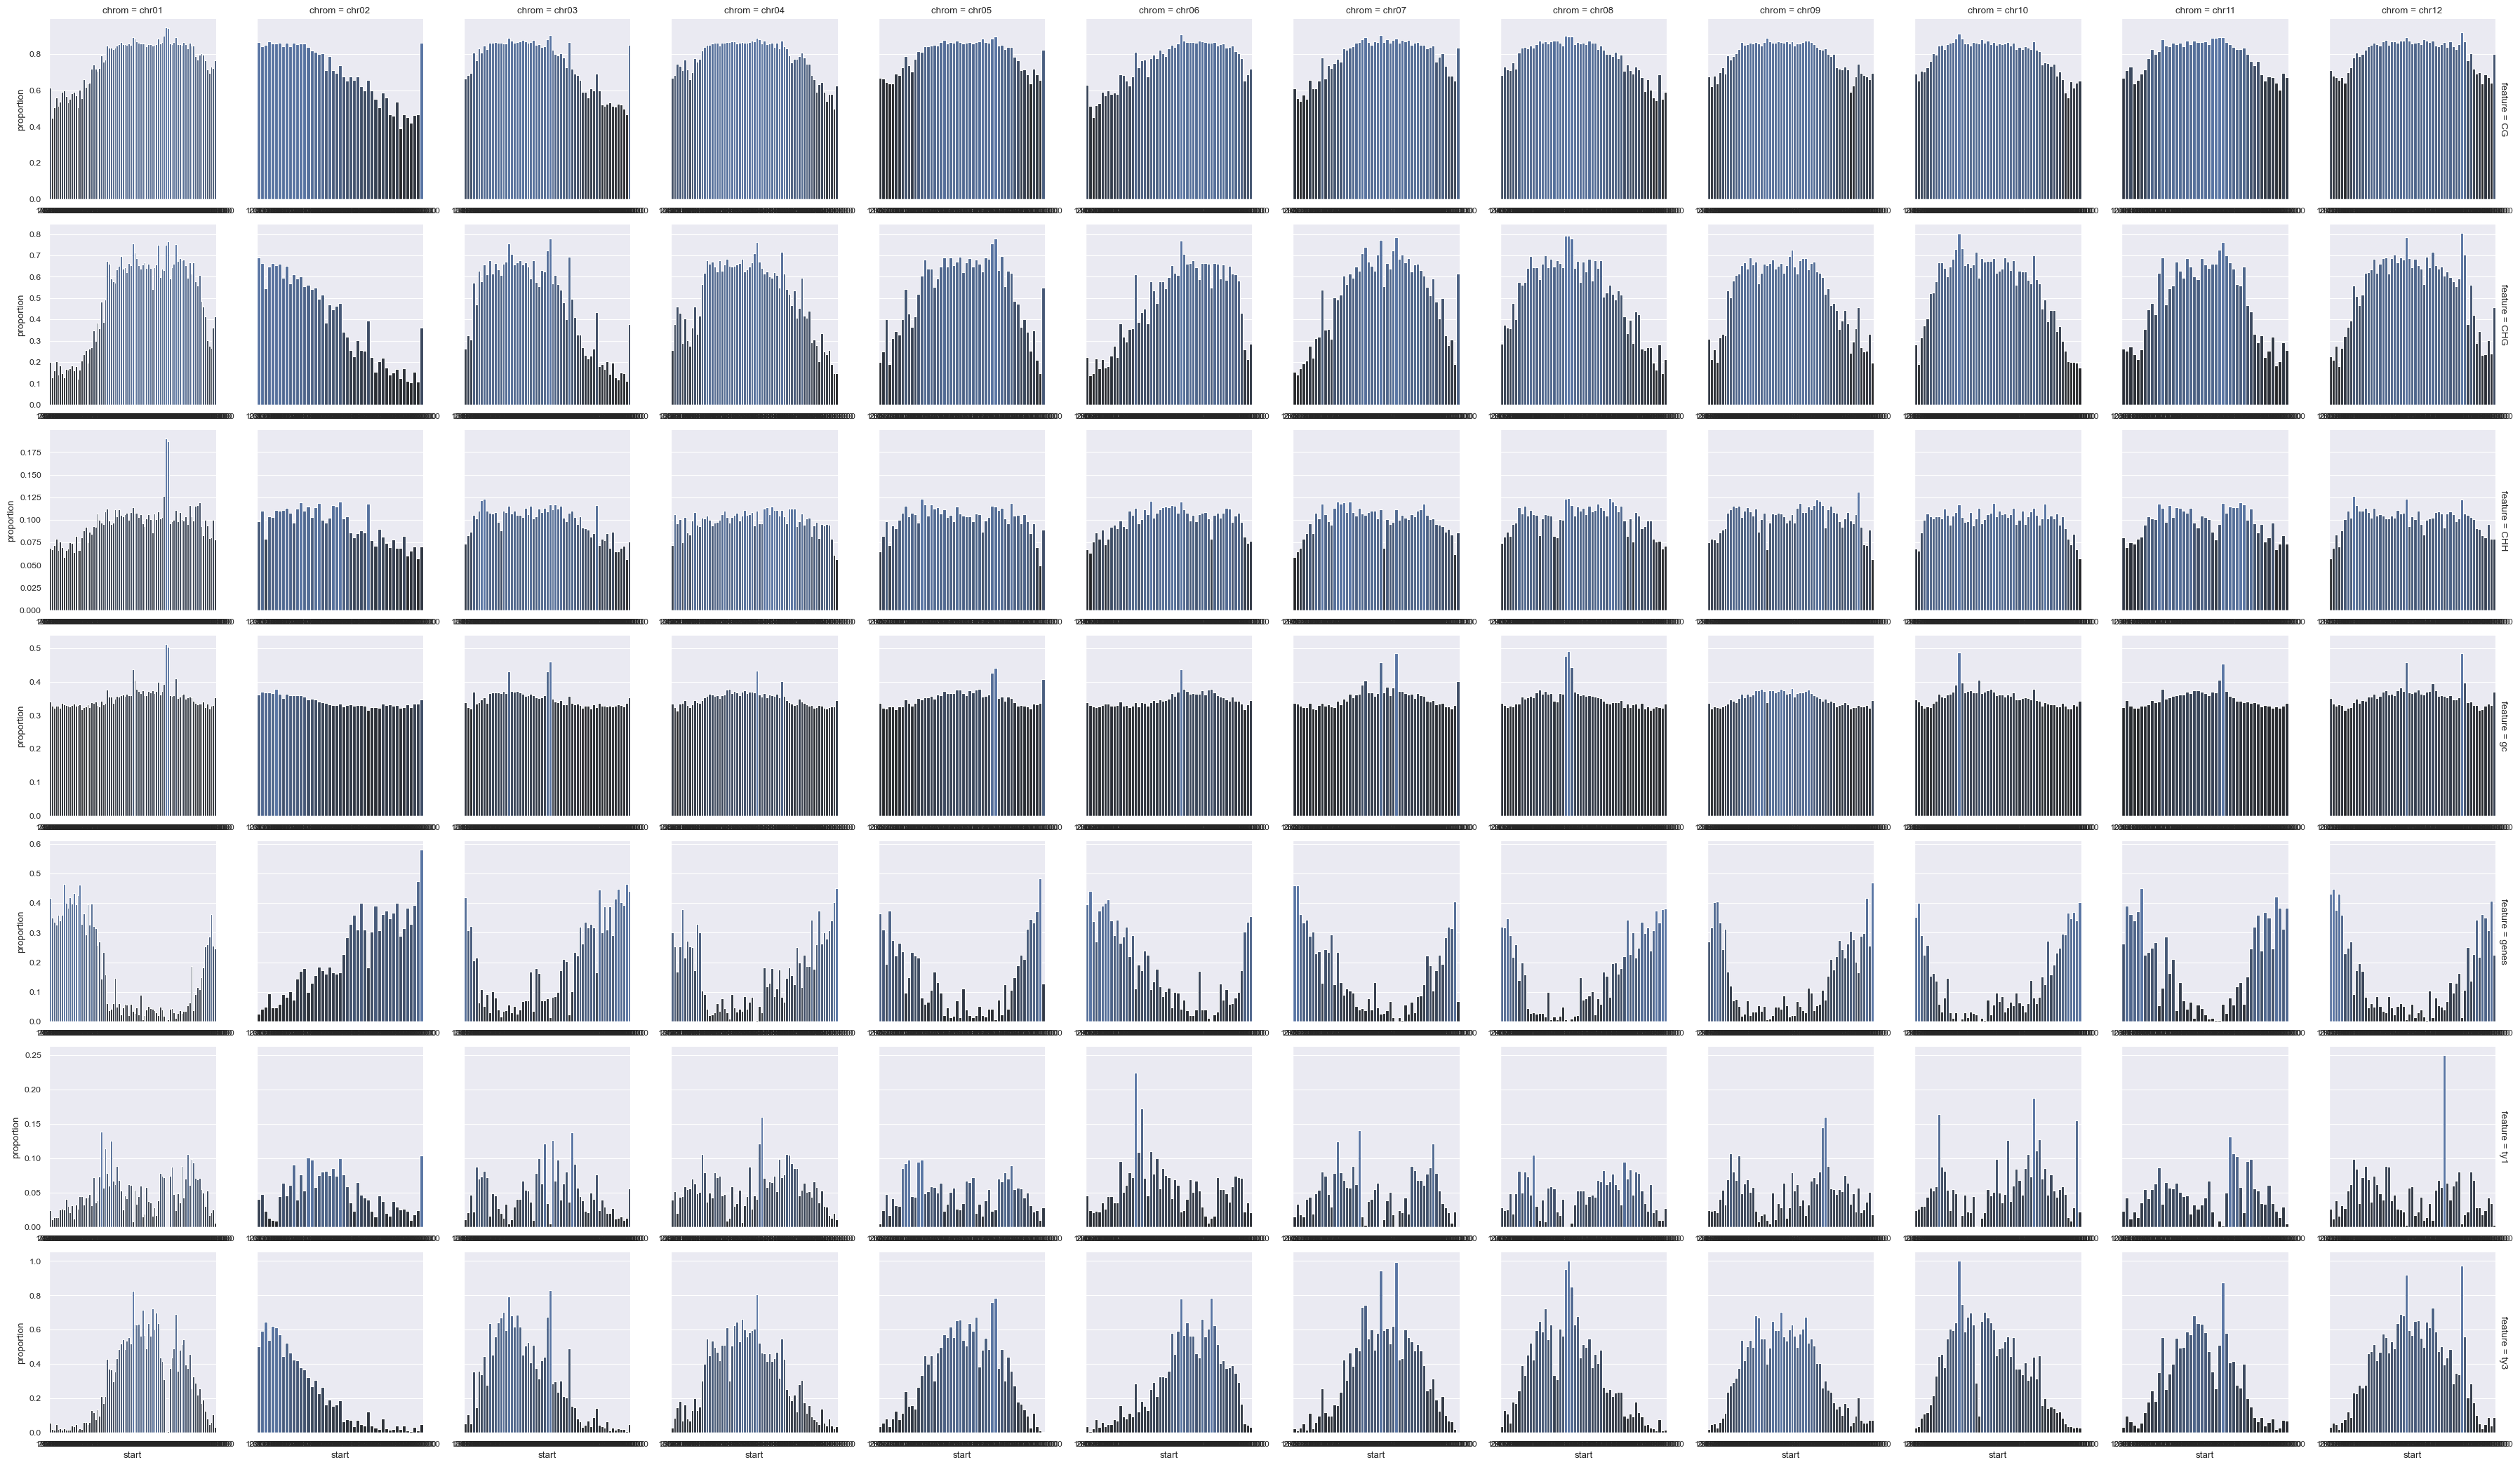

In [5]:
features_df = features_df.filter(pl.col("chrom").str.contains("chr"))

plot = sns.FacetGrid(
    features_df,
    col="chrom",
    row="feature",
    sharex=False,
    sharey="row",
    margin_titles=True,
)

plot.map(
    sns.barplot,
    "start",
    "proportion",
    "proportion",
    width = 1
)

Plot the Hi-C matrix

In [31]:


cooler.fileops.list_coolers("../results/hic/contact_maps/cool/sample1.mcool")

ModuleNotFoundError: No module named 'cooler'

Get some summary statistics and plots for the RNAseq dataset

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_94775/953115225.py:38: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


<Figure size 3540x1800 with 0 Axes>

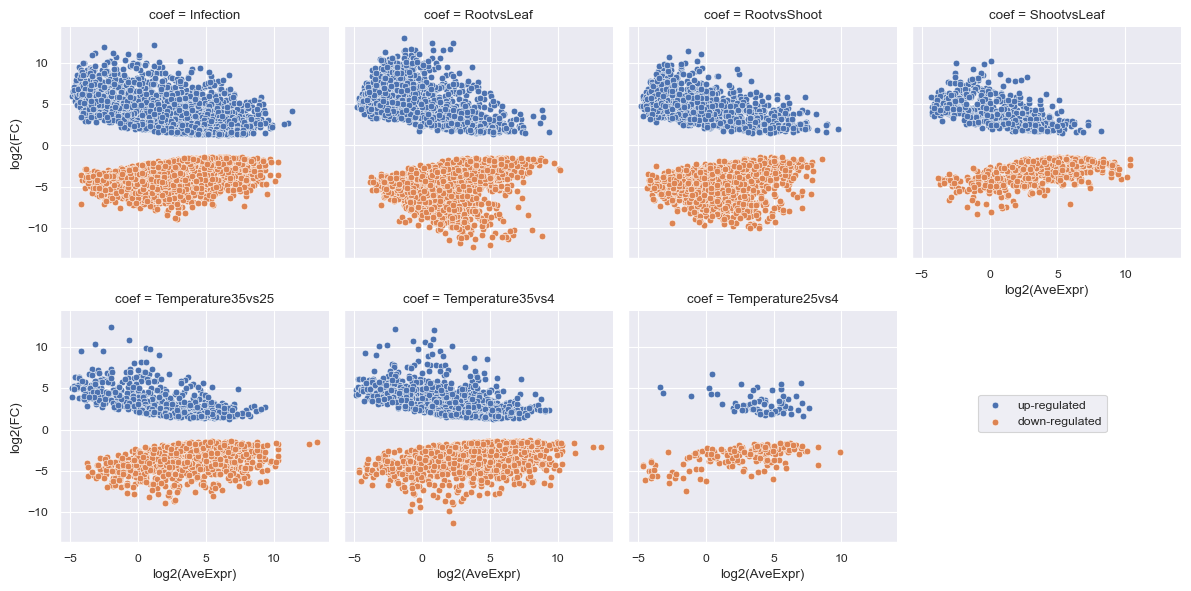

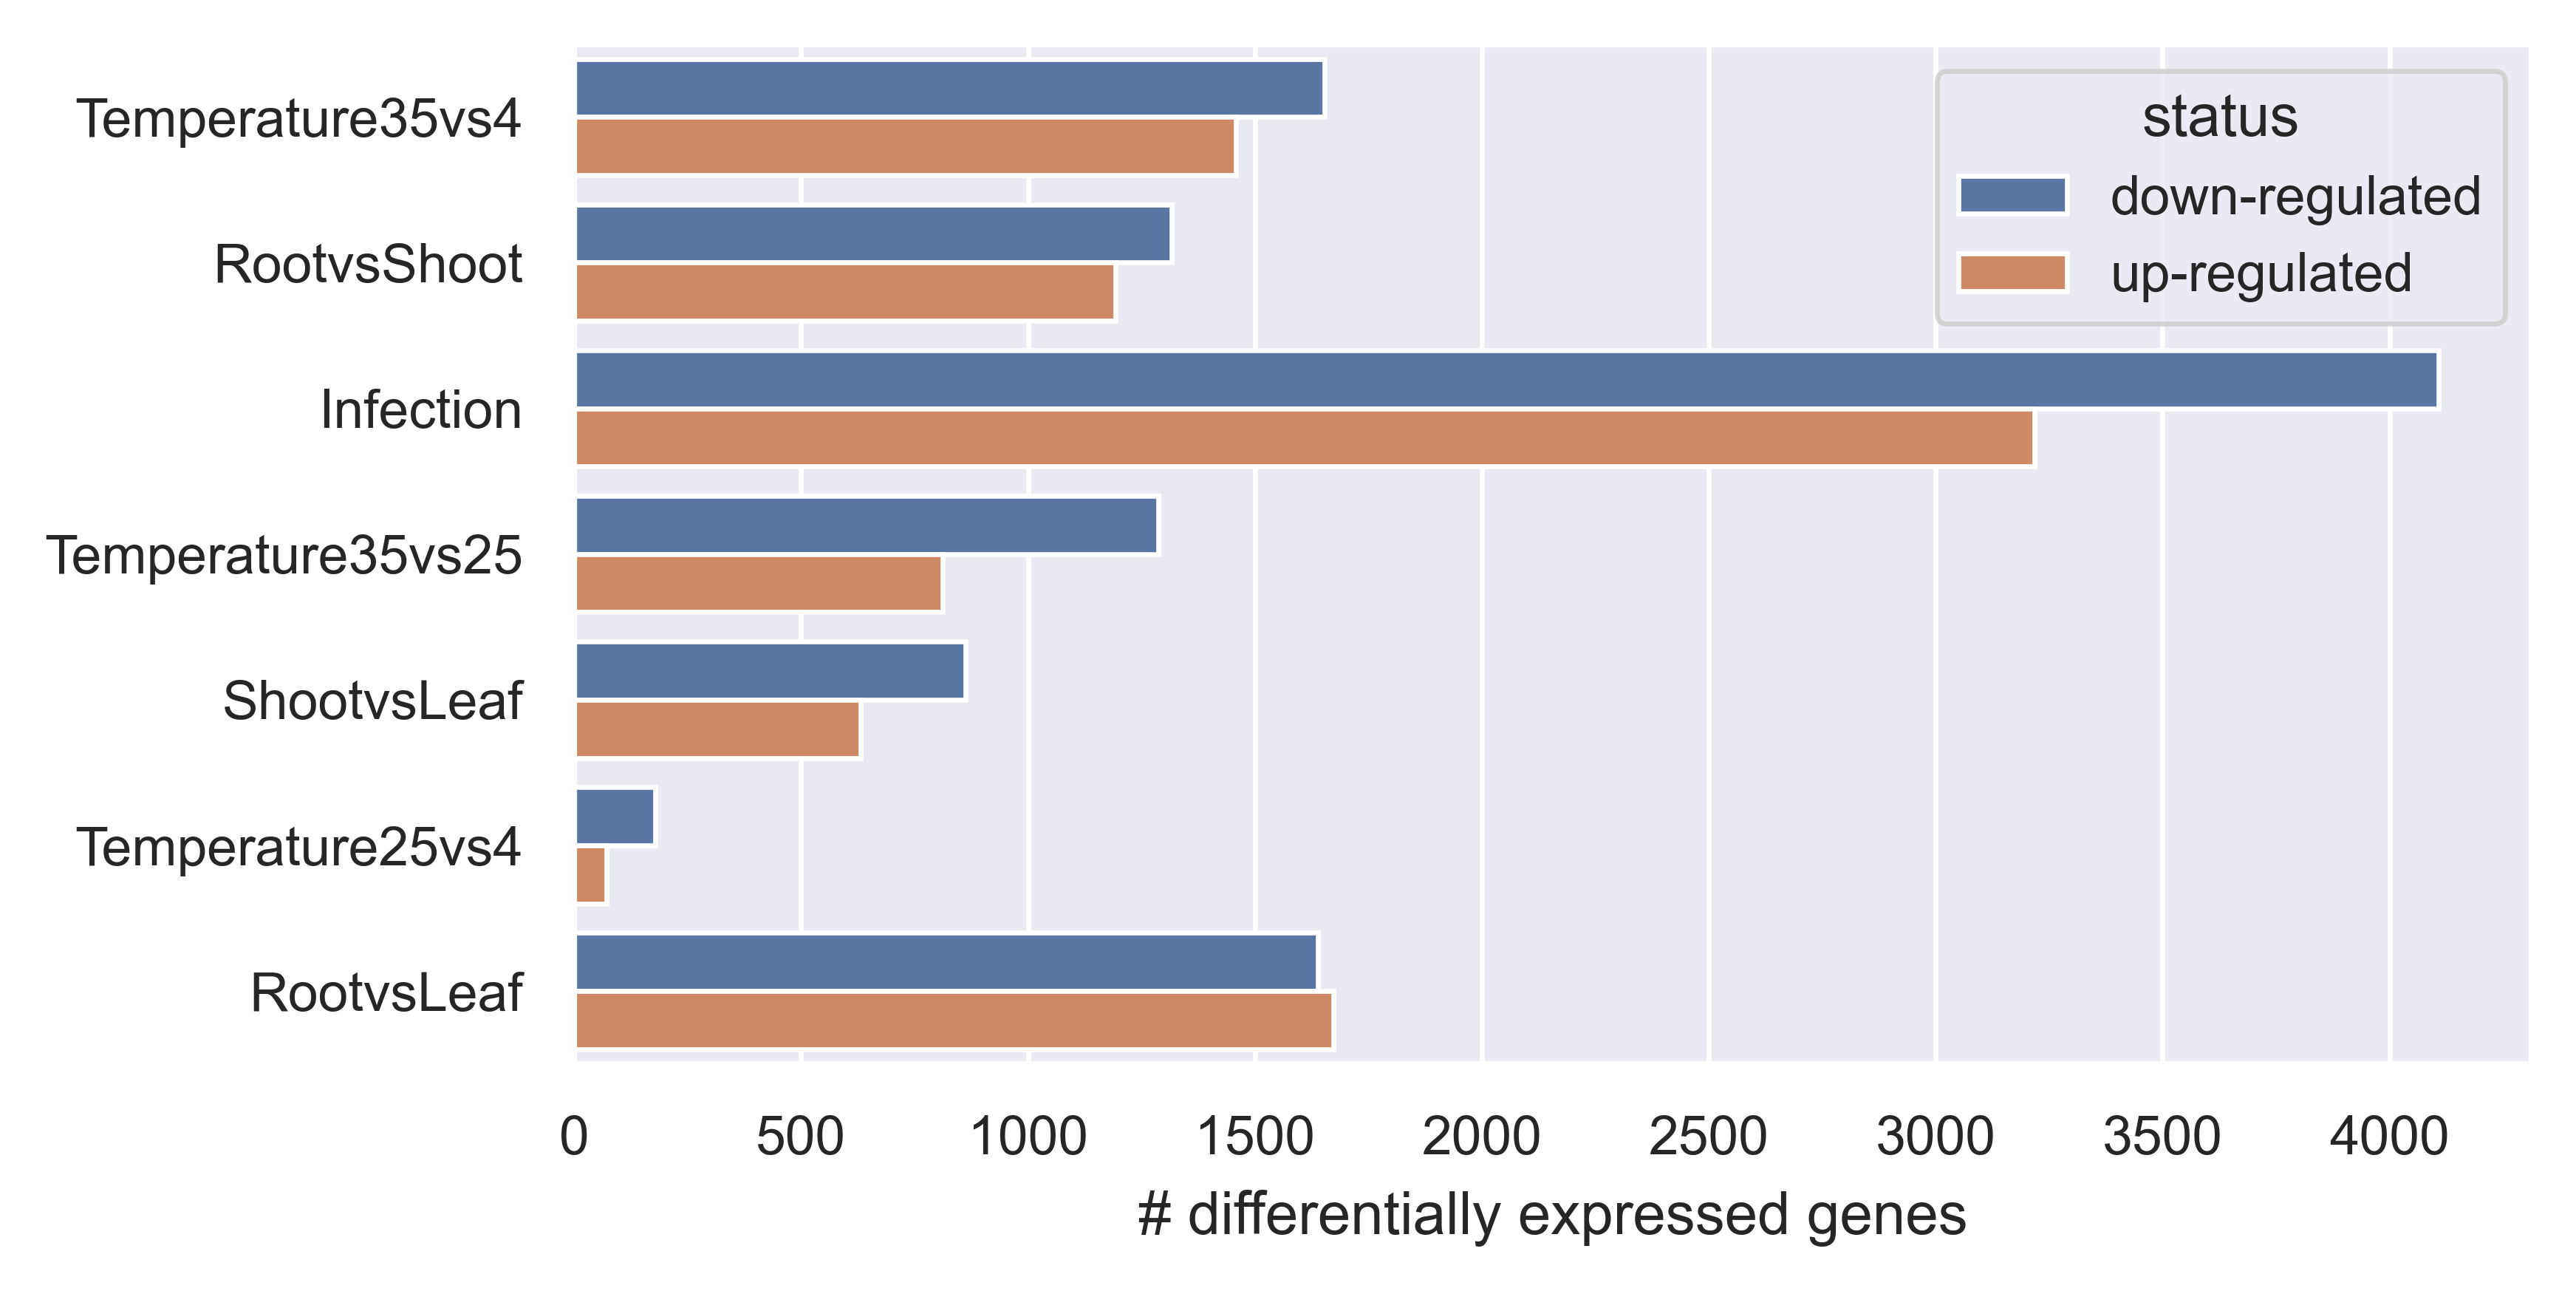

In [27]:
de_genes = pl.read_csv(
    "../results/differential_expression.tsv",
    separator="\t",
    has_header=True,
)

lcpm = (
    pl.read_csv(
        "../results/tpm.tsv",
        separator="\t",
        has_header=True,
    )
    .with_columns((pl.col("tpm") + 1).log10().alias("log_tpm"))
)

plt.figure(figsize=(5.9, 3), dpi=600)
ma_plot = sns.FacetGrid(
    de_genes.filter(pl.col("status") != "not significant"),
    col="coef",
    col_wrap=4,
    hue="status",
)
ma_plot = ma_plot.map(
    sns.scatterplot,
    "AveExpr",
    "logFC",
)
ma_plot.set(xlabel="log2(AveExpr)", ylabel="log2(FC)")
plt.legend(loc="lower right", bbox_to_anchor=(1.8, 0.45))
plt.savefig("../../pandoc-thesis/figures/rnaseq_ma.png")

plt.figure(figsize=(5.9, 3), dpi=600)
de_barplot = sns.barplot(
    (
        de_genes
        .filter(pl.col("status") != "not significant")
        .group_by("coef", "status")
        .count()
    ),
    y="coef",
    x="count",
    hue="status",
)
de_barplot.set(xlabel="# differentially expressed genes", ylabel=None)
plt.tight_layout()
plt.savefig("../../pandoc-thesis/figures/rnaseq_de.png")

Methylation analysis - is gene expression correlated with gbm?

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_94775/3959584408.py:8: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lcpm


                            OLS Regression Results                            
Dep. Variable:                log_tpm   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                 2.582e+04
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:26:33   Log-Likelihood:            -3.9827e+05
No. Observations:              281256   AIC:                         7.966e+05
Df Residuals:                  281248   BIC:                         7.966e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6724      0.004    402.005      0.0

<Axes: xlabel='condition', ylabel='log_tpm'>

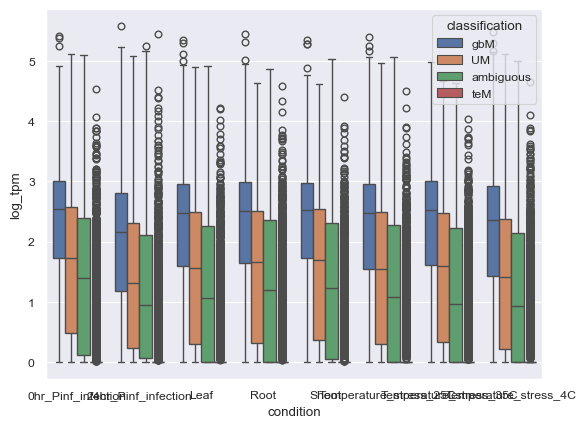